In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import pandas as pd
import shutil
import zipfile

print("✅ Βιβλιοθήκες εγκατεστημένες!")

Mounted at /content/drive
✅ Βιβλιοθήκες εγκατεστημένες!


In [ ]:
# Έλεγχος διαθεσιμότητας GPU
print("GPU:", tf.config.list_physical_devices('GPU'))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!echo "Train images:" && ls /content/data/train_images | head
!echo "Train masks:" && ls /content/data/train_masks | head

!echo "Πλήθος train images:" && ls /content/data/train_images | wc -l
!echo "Πλήθος train masks:" && ls /content/data/train_masks | wc -l

!echo "Πλήθος test masks:" && ls /content/data/test_masks | wc -l

Train images:
002_0300041115_row0_col12.tif
002_0300041115_row0_col13.tif
002_0300041115_row0_col14.tif
002_0300041115_row1_col10.tif
002_0300041115_row1_col13.tif
002_0300041115_row1_col14.tif
002_0300041115_row2_col10.tif
002_0300041115_row2_col11.tif
002_0300041115_row2_col13.tif
002_0300041115_row2_col9.tif
Train masks:
002_0300041115_row0_col12.tif
002_0300041115_row0_col13.tif
002_0300041115_row0_col14.tif
002_0300041115_row1_col10.tif
002_0300041115_row1_col13.tif
002_0300041115_row1_col14.tif
002_0300041115_row2_col10.tif
002_0300041115_row2_col11.tif
002_0300041115_row2_col13.tif
002_0300041115_row2_col9.tif
Πλήθος train images:
22684
Πλήθος train masks:
22684
Πλήθος test masks:
4862


In [ ]:
def extract_zip(zip_path, extract_path):
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"📦 Εξαγωγή στο {extract_path}...")
        file_list = zip_ref.namelist()
        for file in tqdm(file_list, desc="Ανέβασμα"):
            zip_ref.extract(file, extract_path)
        print("✅ Ολοκληρώθηκε!")

# Διαδρομές αρχείων
zip_path = '/content/drive/MyDrive/colab_data/test_images.zip'
extract_path = '/content/data'
extract_zip(zip_path, extract_path)

# Έλεγχος δεδομένων
print("\n📊 Στατιστικά:")
print("Εικόνες εκπαίδευσης:", len(glob("/content/data/train_images/*.tif")))
print("Masks εκπαίδευσης:", len(glob("/content/data/train_masks/*.tif")))

📦 Εξαγωγή στο /content/data...


Ανέβασμα: 100%|██████████| 64818/64818 [05:59<00:00, 180.20it/s] 


✅ Ολοκληρώθηκε!

📊 Στατιστικά:
Εικόνες εκπαίδευσης: 22684
Masks εκπαίδευσης: 22684


In [ ]:
import pandas as pd
import cv2
import os
from tqdm import tqdm

def create_positive_masks_csv(mask_dir, output_path="/content/data/positive_masks.csv", threshold=2000):
    """
    Δημιουργεί CSV αρχείο με πληροφορίες για τα masks που περιέχουν δρόμους
    """
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.tif")))

    data = []
    for mask_path in tqdm(mask_paths, desc="Επεξεργασία masks"):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        positive_pixels = np.sum(mask > 0)
        data.append({
            "filename": os.path.basename(mask_path),
            "positive_pixels": int(positive_pixels),
            "set": "train" if np.random.rand() < 0.8 else "val"  # 80% train, 20% val
        })

    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    return df

# Δημιουργία νέου CSV
mask_dir = "/content/data/train_masks"
pos_df = create_positive_masks_csv(mask_dir)
print(f"✅ Δημιουργήθηκε το {mask_dir}/positive_masks.csv με {len(pos_df)} εγγραφές")

In [ ]:
def load_image_mask_pairs(image_dir, mask_dir):
    return (
        sorted(glob(os.path.join(image_dir, "*.tif"))),
        sorted(glob(os.path.join(mask_dir, "*.tif")))
    )

# Φόρτωση paths
image_paths, mask_paths = load_image_mask_pairs(
    "/content/data/train_images",
    "/content/data/train_masks"
)

# Φόρτωση CSV (υποθέτοντας ότι έχει στήλες: filename, positive_pixels)
pos_df = pd.read_csv("/content/data/positive_masks.csv")

# Επιλογή μόνο των masks με >2000 pixels δρόμου (προσαρμόστε το threshold)
THRESHOLD = 2000
positive_mask_filenames = set(
    pos_df[pos_df["positive_pixels"] > THRESHOLD]["filename"]
)

# Διαχωρισμός θετικών/αρνητικών
pos_imgs = [img for img, mask in zip(image_paths, mask_paths)
            if os.path.basename(mask) in positive_mask_filenames]
pos_masks = [mask for mask in mask_paths
             if os.path.basename(mask) in positive_mask_filenames]

neg_imgs = [img for img, mask in zip(image_paths, mask_paths)
            if os.path.basename(mask) not in positive_mask_filenames]
neg_masks = [mask for mask in mask_paths
             if os.path.basename(mask) not in positive_mask_filenames]

# Δειγματοληψία 20% αρνητικών (ΜΟΝΟ αν υπάρχουν αρνητικά δείγματα)
if len(neg_imgs) > 0:
    neg_imgs_sample, _, neg_masks_sample, _ = train_test_split(
        neg_imgs, neg_masks, test_size=0.8, random_state=42
    )
else:
    neg_imgs_sample, neg_masks_sample = [], []
    print("⚠️ Δεν βρέθηκαν αρνητικά δείγματα - χρήση μόνο θετικών")

# Τελικό split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    pos_imgs + neg_imgs_sample,
    pos_masks + neg_masks_sample,
    test_size=0.2,
    random_state=42
)

print(f"\n📊 Τελικό Dataset:")
print(f"- Θετικά δείγματα: {len(pos_imgs)}")
print(f"- Αρνητικά δείγματα (20% sample): {len(neg_imgs_sample)}")
print(f"- Σύνολο Train: {len(train_imgs)}")
print(f"- Σύνολο Val: {len(val_imgs)}")

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.5
    ),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.1),
    A.CLAHE(p=0.1),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

print("✅ Augmentation pipeline ready!")

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

class RoadDataset(Sequence):
    def __init__(self, images, masks, transform=None, batch_size=8, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # ΠΡΟΣΟΧΗ: Αυτή η γραμμή είναι κρίσιμη
        self.images = images
        self.masks = masks
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, idx):
       batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
       batch_imgs = [self.images[i] for i in batch_indices]
       batch_masks = [self.masks[i] for i in batch_indices]

       imgs, masks = [], []
       for img_path, mask_path in zip(batch_imgs, batch_masks):
        # Φόρτωση εικόνας
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32) / 255.0  # Κανονικοποίηση [0,1]

        # Φόρτωση μάσκας
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1)
        mask = (mask > 0).astype(np.float32)  # Δυαδικοποίηση [0,1]

        imgs.append(img)
        masks.append(mask)

       return np.array(imgs), np.array(masks)

# Δημιουργία DataLoaders
train_ds = RoadDataset(train_imgs, train_masks, transform=transform)
val_ds = RoadDataset(val_imgs, val_masks, transform=transform)

print("✅ DataLoaders ready!")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = squeeze_excite_block(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(input_tensor, filters):
    x = conv_block(input_tensor, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)
    return keras.Model(inputs, outputs)

model = build_unet()
print("✅ Model built!")
model.summary()

In [ ]:
# Χρησιμοποιήστε τις υπάρχουσες συναρτήσεις σας όπως είναι
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# 1. Ορισμός συνάρτησης loss
def weighted_bce_dice_loss(y_true, y_pred, weight_background=0.2, weight_road=0.8):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Εξασφαλίζουμε ότι τα weights έχουν ίδιο dtype
    dtype = y_true_f.dtype
    weight_background = tf.constant(weight_background, dtype=dtype)
    weight_road = tf.constant(weight_road, dtype=dtype)

    weights = tf.where(y_true_f > 0.5, weight_road, weight_background)

    intersection = tf.reduce_sum(weights * y_true_f * y_pred_f)
    union = tf.reduce_sum(weights * (y_true_f + y_pred_f))
    dice = (2. * intersection + 1e-6) / (union + 1e-6)

    return bce + (1 - dice)


# 2. Υπολογισμός class weights
def calculate_class_weights(mask_paths):
    road_pixels = 0
    background_pixels = 0

    for path in tqdm(mask_paths, desc="Calculating weights"):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        road_pixels += np.sum(mask > 0)
        background_pixels += np.sum(mask == 0)

    total = road_pixels + background_pixels
    return {
        0: total / (2. * background_pixels),  # Background weight
        1: total / (2. * road_pixels)         # Road weight
    }

# 3. Compile μοντέλου
class_weights = calculate_class_weights(train_masks)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric]
)

In [ ]:
def calculate_class_weights(mask_paths):
    road_pixels = 0
    background_pixels = 0

    for path in tqdm(mask_paths, desc="Calculating class weights"):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        road_pixels += np.sum(mask > 0)
        background_pixels += np.sum(mask == 0)

    total = road_pixels + background_pixels
    weight_for_0 = total / (2.0 * background_pixels)  # Background
    weight_for_1 = total / (2.0 * road_pixels)       # Road

    return {0: weight_for_0, 1: weight_for_1}

class_weights = calculate_class_weights(train_masks)
print("Class weights:", class_weights)

In [ ]:


# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor="val_iou_metric",
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_iou_metric",
        patience=10,
        mode='max',
        restore_best_weights=True
    )
]

# Εκπαίδευση
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

# Αποθήκευση
model.save("road_segmentation_model.h5")
print("✅ Model saved!")

In [ ]:
!ls "/content/drive/MyDrive/path/to/"  # Για επιβεβαίωση ότι το αρχείο υπάρχει

ls: cannot access '/content/drive/MyDrive/path/to/': No such file or directory


In [ ]:
# Αντιγραφή μοντέλου και ιστορικού
shutil.copy("road_segmentation_model.h5", "/content/drive/MyDrive/")
shutil.copy("positive_masks.csv", "/content/drive/MyDrive/")

print("✅ Τα αρχεία αποθηκεύτηκαν στο Drive!")

In [ ]:
# Κελί 1: Σύνδεση με Drive και εισαγωγές
from google.colab import drive
from tensorflow import keras
import tensorflow as tf

drive.mount('/content/drive')

In [ ]:
# Κελί 2: Αυτοματοποιημένη φόρτωση μοντέλου
def load_model_with_retry(max_retries=3):
    """Φόρτωση μοντέλου με δυνατότητα επανάληψης σε περίπτωση σφάλματος"""
    model_path = '/content/drive/MyDrive/road_segmentation_model.h5'

    # Ορισμός custom objects (προσαρμόστε ανάλογα)
    custom_objects = {
        'iou_metric': lambda y_true, y_pred: tf.reduce_mean(
            tf.keras.metrics.binary_accuracy(y_true, y_pred > 0.5))
    }

    for attempt in range(max_retries):
        try:
            model = keras.models.load_model(
                model_path,
                custom_objects=custom_objects
            )
            print(f"✅ Επιτυχής φόρτωση μετά από {attempt+1} προσπάθειες")
            return model
        except Exception as e:
            print(f"⚠️ Προσπάθεια {attempt+1} αποτυχία: {str(e)}")
            if attempt == max_retries - 1:
                raise RuntimeError(f"Αδυναμία φόρτωσης μετά από {max_retries} προσπάθειες") from e
            time.sleep(2)  # Αναμονή πριν επανάληψη

# Χρήση
try:
    model = load_model_with_retry()
    print("Τύπος μοντέλου:", type(model))
    print("Σύνοψη μοντέλου:")
    model.summary()
except Exception as e:
    print(f"❌ Κρίσιμο σφάλμα: {e}")
    print("Παρακαλώ ελέγξτε:")
    print("1. Αν το αρχείο υπάρχει: !ls '/content/drive/MyDrive/'")
    print("2. Αν οι custom συναρτήσεις ταιριάζουν με αυτές της εκπαίδευσης")

✅ Επιτυχής φόρτωση μετά από 1 προσπάθειες
Τύπος μοντέλου: <class 'keras.src.models.functional.Functional'>
Σύνοψη μοντέλου:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_18[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1, 1, 4)   │        260 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1, 1, 64)  │        320 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 256, 256,  │          0 │ re_lu_18[0][0],   │
│ (Multiply)          │ 64)               │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ multiply_9[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_20[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 31,276,539 (119.31 MB)

 Trainable params: 31,264,761 (119.27 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
!pip install rasterio
import tensorflow as tf
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. Ορισμός μετρικής
class IoUMetric(tf.keras.metrics.MeanIoU):
    def __init__(self, name='iou_metric', dtype=None):
        super().__init__(num_classes=2, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, self._dtype)
        return super().update_state(y_true, y_pred, sample_weight)

# 2. Φόρτωση μοντέλου
model = load_model('/content/drive/MyDrive/road_segmentation_model.h5',
                  custom_objects={'iou_metric': IoUMetric()})

# 3. Βελτιωμένη φόρτωση TIFF (με μετατροπή σε RGB)
def load_and_convert_tiff(img_path, mask_path, img_size=(256, 256)):
    def _load(path, channels=3):
        with rasterio.open(path.numpy().decode('utf-8')) as src:
            arr = src.read()  # (C, H, W)
            if arr.shape[0] > channels:
                arr = arr[:channels]  # Κρατάμε μόνο τα πρώτα N κανάλια
            elif arr.shape[0] < channels:
                arr = np.repeat(arr, channels, axis=0)  # Αντιγραφή για RGB
        return tf.image.resize(tf.convert_to_tensor(arr.transpose(1, 2, 0), dtype=tf.float32), img_size)

    img = tf.py_function(lambda x: _load(x, 3), [img_path], tf.float32)  # Πάντα 3 κανάλια
    mask = tf.py_function(lambda x: _load(x, 1), [mask_path], tf.float32)  # Πάντα 1 κανάλι

    img.set_shape((*img_size, 3))
    mask.set_shape((*img_size, 1))

    return img/255.0, tf.cast(mask>0, tf.float32)

# 4. Δημιουργία Dataset
VAL_IMG_DIR = '/content/data/val_images'
VAL_MASK_DIR = '/content/data/val_masks'

val_img_paths = sorted([os.path.join(VAL_IMG_DIR, f) for f in os.listdir(VAL_IMG_DIR) if f.endswith('.tif')])
val_mask_paths = sorted([os.path.join(VAL_MASK_DIR, f) for f in os.listdir(VAL_MASK_DIR) if f.endswith('.tif')])

val_ds = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths))
val_ds = val_ds.map(load_and_convert_tiff, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

print(f"✅ Φορτώθηκαν {len(val_img_paths)} εικόνες TIFF (με αυτόματη μετατροπή καναλιών)")


✅ Φορτώθηκαν 4860 εικόνες TIFF (με αυτόματη μετατροπή καναλιών)


📊 Αξιολόγηση μοντέλου:
608/608 ━━━━━━━━━━━━━━━━━━━━ 64s 98ms/step - accuracy: 0.9716 - iou_metric: 0.7656 - loss: 0.0836
Validation Loss: 0.0897
Validation Accuracy: 0.9700
Validation IoU: 0.7668

🎨 Οπτικοποίηση προβλέψεων:


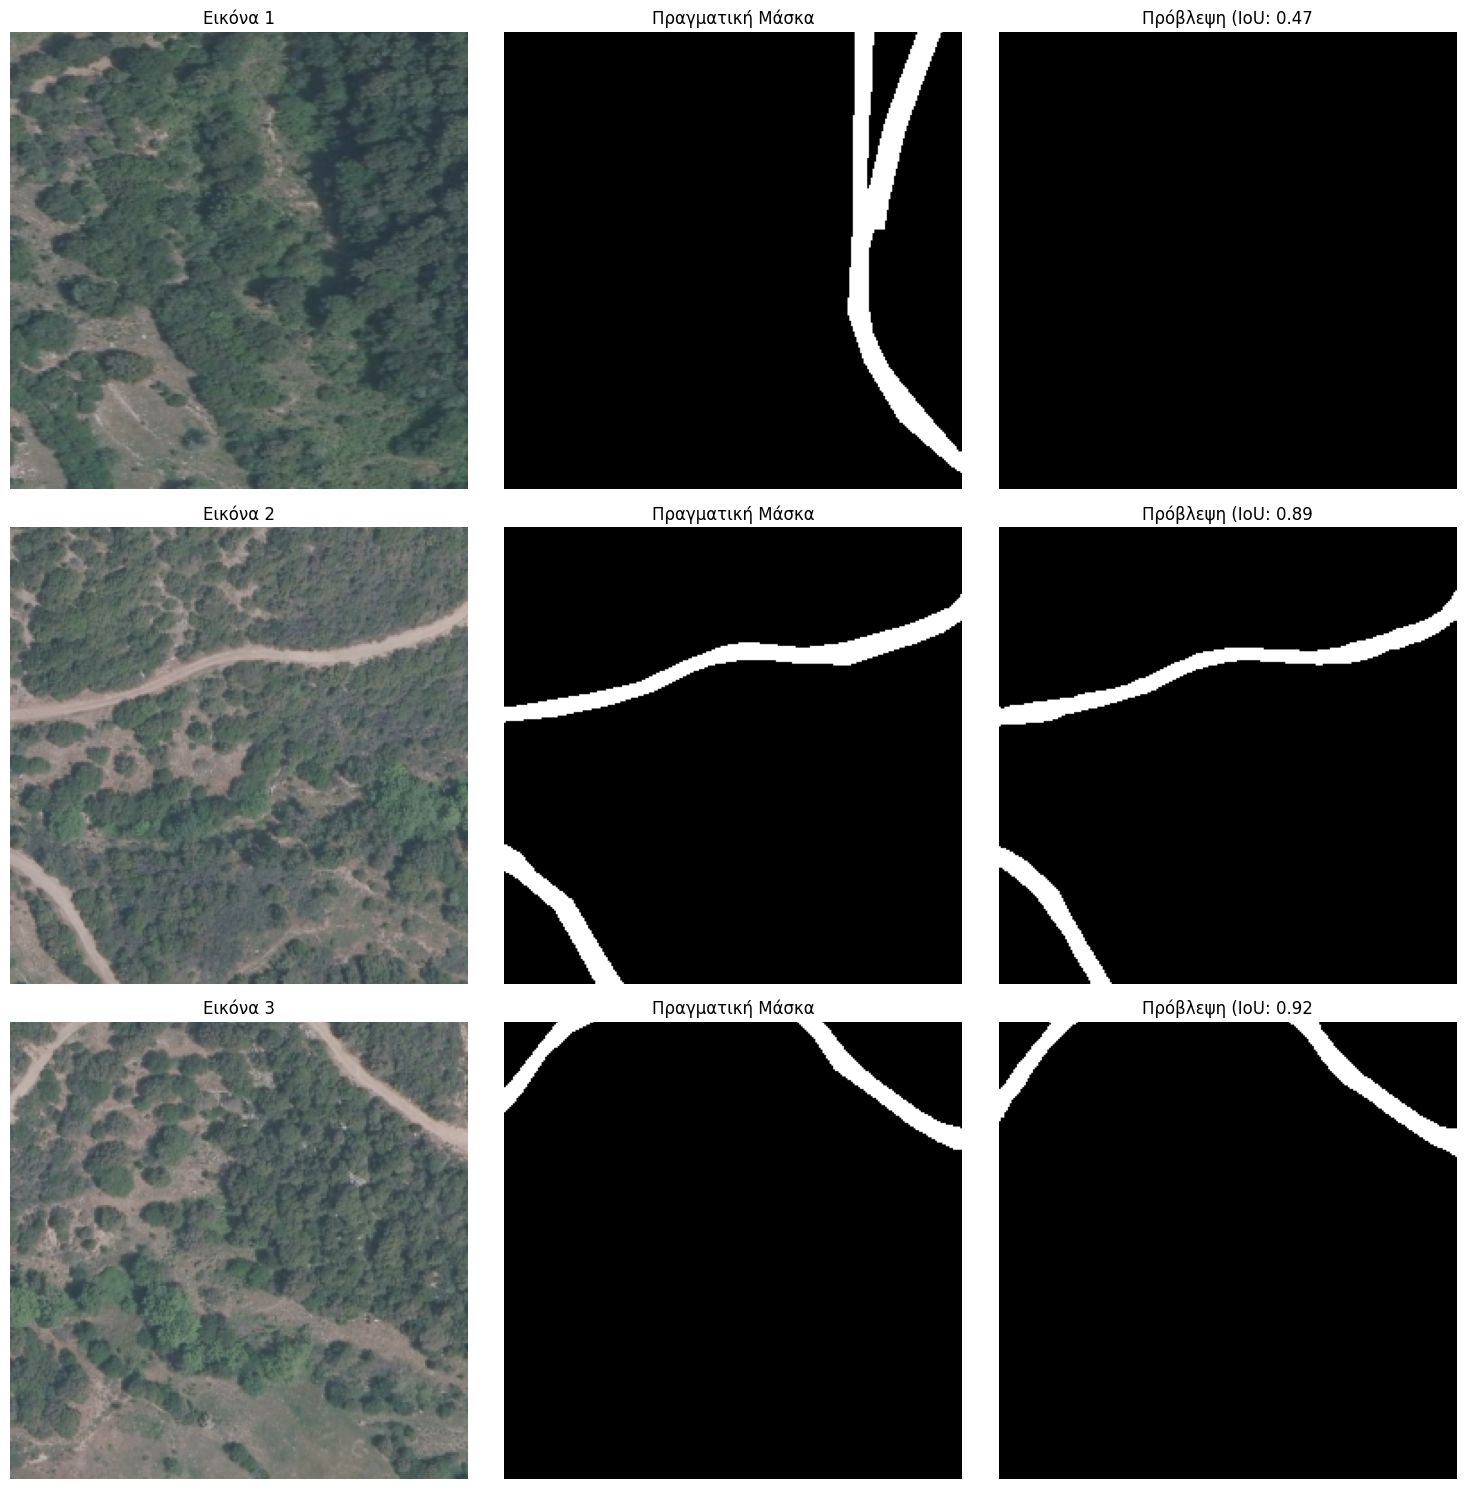

In [ ]:
# 1. Αξιολόγηση
print("📊 Αξιολόγηση μοντέλου:")
try:
    results = model.evaluate(val_ds, verbose=1)
    print(f"Validation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")
    print(f"Validation IoU: {results[2]:.4f}")
except Exception as e:
    print(f"Σφάλμα αξιολόγησης: {str(e)}")

# 2. Οπτικοποίηση
def visualize_predictions(dataset, model, n_samples=3):
    plt.figure(figsize=(15, 5*n_samples))
    for i, (img, mask) in enumerate(dataset.unbatch().take(n_samples)):
        # Πρόβλεψη
        pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)[0]

        # Οπτικοποίηση
        plt.subplot(n_samples, 3, 3*i+1)
        plt.imshow(img.numpy().clip(0, 1))
        plt.title(f"Εικόνα {i+1}")
        plt.axis('off')

        plt.subplot(n_samples, 3, 3*i+2)
        plt.imshow(mask.numpy().squeeze(), cmap='gray')
        plt.title("Πραγματική Μάσκα")
        plt.axis('off')

        plt.subplot(n_samples, 3, 3*i+3)
        plt.imshow(pred.squeeze() > 0.5, cmap='gray')
        plt.title(f"Πρόβλεψη (IoU: {IoUMetric()(mask, pred).numpy():.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n🎨 Οπτικοποίηση προβλέψεων:")
visualize_predictions(val_ds, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


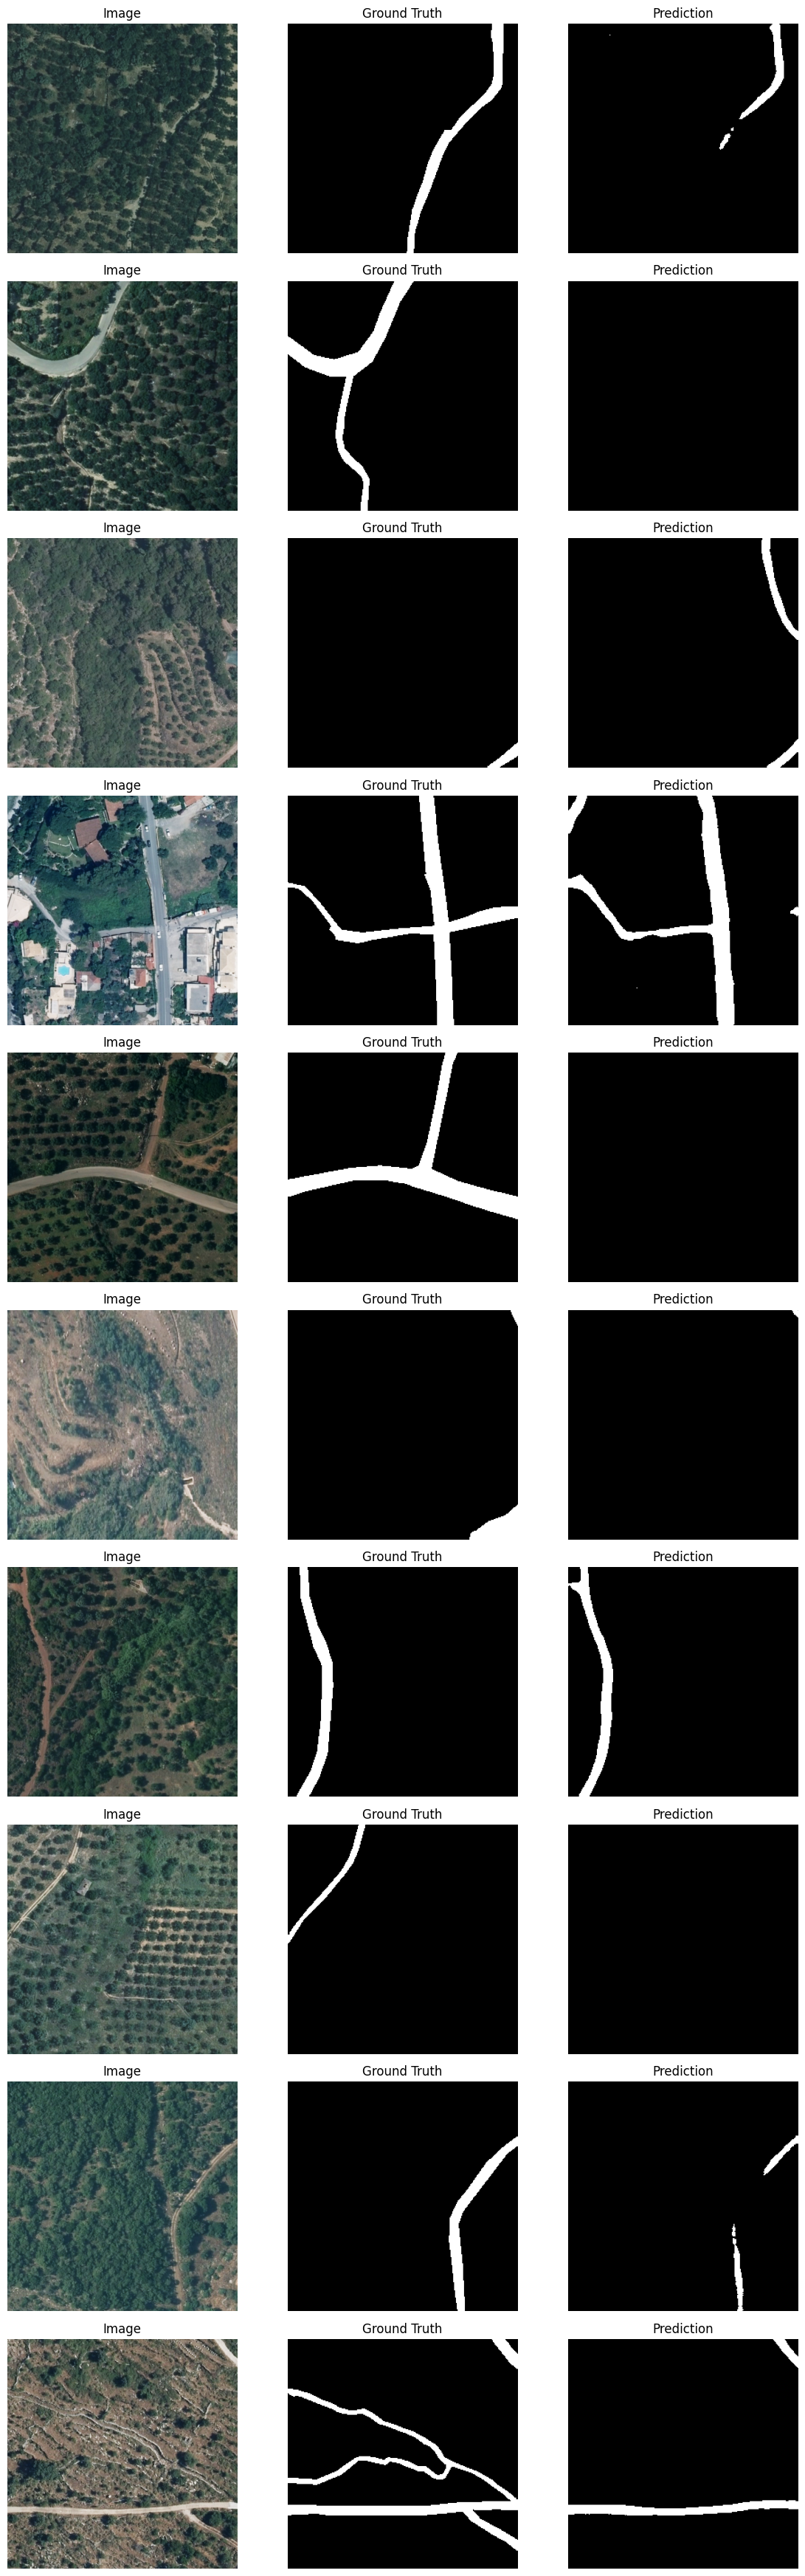

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# ✅ Το μοντέλο θεωρείται ήδη φορτωμένο ως: model

# Paths
image_folder = "/content/data/test_images"
mask_folder = "/content/data/test_masks"

# Λίστα αρχείων
image_files = sorted(glob(os.path.join(image_folder, "*.tif")))
mask_files = sorted(glob(os.path.join(mask_folder, "*.tif")))
indices = random.sample(range(len(image_files)), 10)

# ✅ Προεπεξεργασία εικόνας
def preprocess_img(img, target_size=(256, 256)):
    img = img.resize(target_size)
    img_np = np.array(img)

    # Αν έχει 4 κανάλια (RGBA), κρατάμε μόνο τα 3 πρώτα (RGB)
    if img_np.ndim == 3 and img_np.shape[2] > 3:
        img_np = img_np[:, :, :3]

    # Αν είναι μονόκαναλη (grayscale), την κάνουμε 3 κανάλια
    if img_np.ndim == 2:
        img_np = np.stack([img_np] * 3, axis=-1)

    img_np = img_np / 255.0
    return img_np

# Προβολή
fig, axes = plt.subplots(10, 3, figsize=(12, 35))
for idx, i in enumerate(indices):
    img = Image.open(image_files[i])
    gt = Image.open(mask_files[i]).convert("L")

    # Resize & normalize image
    img_resized = preprocess_img(img)
    input_tensor = np.expand_dims(img_resized, axis=0)  # shape (1, H, W, C)

    # Predict
    pred = model.predict(input_tensor)[0]
    pred_mask = (pred.squeeze() > 0.5).astype("uint8") * 255

    # Ground truth resized
    gt_resized = np.array(gt.resize((256, 256)))

    # Αν RGB
    img_disp = img.convert("RGB")

    # Εμφάνιση
    axes[idx, 0].imshow(img_disp)
    axes[idx, 0].set_title("Image")

    axes[idx, 1].imshow(gt_resized, cmap="gray")
    axes[idx, 1].set_title("Ground Truth")

    axes[idx, 2].imshow(pred_mask, cmap="gray")
    axes[idx, 2].set_title("Prediction")

    for j in range(3):
        axes[idx, j].axis('off')

plt.tight_layout()
plt.show()
